# TP1: Classifieur linéaire, fonction de perte **Hinge** de type **one-vs-one**

In [1]:
import random
import time
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)
    X_batch -= np.mean(X_batch, axis = 0)

    # Ajout du biais
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    X_batch = np.hstack([X_batch, np.ones((X_batch.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)


## Classifieur linéaire avec fonction de perte de type "Hinge loss"

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `hinge_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  

**NOTE IMPORTANTE**: les solutions que vous devez obtenir proviennent d'une implantation de type **one-vs-one** de la fonction *Hinge*.  Si nous aviez à coder une solution **one-vs-all** (également appelée *one-vs-rest*) vous devriez obtenir une loss de 8.63 (au lieu de 1.28) pour la cellule suivante et 9.09 (au lieu de 1.53) pour la cellule d'après.


In [4]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction hinge_naive_forward_backward située dans le fichier           #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import hinge_naive_forward_backward

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, _ = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.28220758164
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

Bravo!
loss error: 0.000000


In [5]:
##############################################################################
# TODO: Même chose qu'à la cellule précédente mais...                        #
#   vec N=500 images et autant de cibles                                     #
##############################################################################

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 1.53644079
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


Bravo!
loss error: 0.000000


## Question 1:
   
Expliquez pourquoi lorsque la matrice de poids W est initialisée avec des valeurs proches de zéro, la **hinge loss** tend vers 1.0.

**Réponse** :
Si les poids dans $W$ tendent tous vers 0, cela implique que les produits scalaires pour chaque classe vont également tendre vers 0. Cela est vrai en particulier pour la prédiction associée au résulat maximal $W^t_{argmax}x_i$ et la prédiction associée à la classe de la vérité terrain $W^t_{t_i}x_i$. Ainsi, on aura  $max(0, 1 + W^t_{argmax}x_i - W^t_{t_i}x_i) \approx max(0, 1 + 0 - 0) = max(0,1) = 1$ pour l'ensemble des observations (vecteurs) $x_i$.

## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [6]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       hinge_naive_forward_backward située dans le fichier utils.loss       #
#                                                                            #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.011288303265
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([0.0, 1.28672636, 0.0])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [7]:
##############################################################################
# TODO:                                                                      #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.5373299967
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-2.395425, -0.840625, -0.32925, 7.256375])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de la hinge loss (et de son gradient) via la fonction *hinge_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le test du **gradient numérique**

In [8]:
##############################################################################
# En principe, le fait d'augmenter le terme de régularisation L2 devrait     #
# augmenter la loss...                                                       #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.5
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


1.6084429380096152
1.6161129501398999
1.6276179683353267
1.644875495628467
1.6707617865681776
1.7095912229777435
1.7678353775920923
1.8552016095136155
1.9862509573959002
2.182824979219327
Bravo!


In [9]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

numerical: -0.559968, analytic -0.559968, relative error: 3.250365e-10
numerical: -1.060812, analytic -1.060812, relative error: 9.403298e-12
numerical: -3.094440, analytic -3.094440, relative error: 5.095909e-11
numerical: -1.731708, analytic -1.731708, relative error: 3.112553e-11
numerical: -3.136784, analytic -3.136784, relative error: 3.391662e-11
numerical: -5.398616, analytic -5.398616, relative error: 5.313220e-11
numerical: 3.208200, analytic 3.208200, relative error: 1.039212e-12
numerical: -4.139140, analytic -4.139140, relative error: 2.321932e-11
numerical: -1.319408, analytic -1.319408, relative error: 7.155325e-11
numerical: -0.154112, analytic -0.154112, relative error: 9.173011e-10

------------
Gradient check : reg=1e-2
------------

numerical: 1.966363, analytic 1.966363, relative error: 1.285016e-10
numerical: 2.082740, analytic 2.082740, relative error: 1.323520e-10
numerical: 3.179947, analytic 3.179947, relative 

## Hinge loss et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **hinge_naive_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

### Question 2:  
Les prochaines étapes consistent à implanter le calcul de la loss et du gradient de la loss de façon **linéarisée**.  Avant de commencer à coder, veuillez donner ici la formule de la loss et du gradient pour une mini-batch de 500 données contenue dans le tableau 

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

Soient $Y\in R^{500\times 10}, Y = XW$ la matrice contenant les prédictions pour l'ensemble des observations d'une mini-batch, $A \in R^{500\times 10}$ une matrice où chaque ligne $a_{i,\cdot}$ consitue un one-hot encoding où l'unique valeur non nulle 1 se retrouve à la position de la vrai classe $(t_i)$ associée à l'observation $x_i$, et $B \in R^{500\times 10}$ une matrice où chaque ligne $b_{i,\cdot}$ consitue un one-hot encoding où l'unique valeur non nulle 1 se retrouve à la position de la classe prédite par le classifieur pour l'observation $x_i$. Notons finalement $v_1 \in R^{500\times1}, v_2 \in R^{10\times1}$ deux vecteurs comprenant seulement des 1. On obtient alors :  

$$Loss = \frac{1}{500}v_1^{T}C + \frac{1}{2}\lambda\Vert W\Vert_F^2 \ \ where \ \ C=max(0, v_1 + (Y\circ(B-A))v_2)$$

$$dW = \frac{1}{500}X^T(B-A) + \lambda W$$

**NOTE IMPORTANT** : la réponse à cette question ne contient aucune boucle, seulement des multiplications matricielles et ventorielles.  De plus, la solution ayant au plus 15 lignes en Python, inutile de complexifiée inutilement la réponse.  En d'autres mots, on attend une réponse de quelques lignes (et non quelques pages!). 

In [10]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction hinge_naive_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
start = time.time()
loss_naive, grad_naive = hinge_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import hinge_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = hinge_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pour le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

naive loss: 1.593103e+00 computed in 0.034113s
vectorized loss: 1.593103e+00 computed in 0.008578s
bravo pour la loss!
Loss difference: 0.000000
bravo pour le gradient !
Gradient difference: 0.000000


## Entraînement
À l'aide de la classe **LinearClassifier** (dans *model/LinearClassifier.py*) ainsi que de la fonction vectorisée **hinge_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

Epoch 0 - Loss : 7.19557
Epoch 1 - Loss : 6.92877
Epoch 2 - Loss : 6.8318
Epoch 3 - Loss : 6.88687
Epoch 4 - Loss : 6.85951
Epoch 5 - Loss : 6.89284
Epoch 6 - Loss : 6.6092
Epoch 7 - Loss : 7.28575
Epoch 8 - Loss : 6.99906
Epoch 9 - Loss : 6.82161
Epoch 10 - Loss : 6.56474
Epoch 11 - Loss : 6.72117
Epoch 12 - Loss : 7.08027
Epoch 13 - Loss : 7.11458
Epoch 14 - Loss : 6.57453
Epoch 15 - Loss : 6.94464
Epoch 16 - Loss : 6.53682
Epoch 17 - Loss : 6.59803
Epoch 18 - Loss : 6.48447
Epoch 19 - Loss : 6.62993
Epoch 20 - Loss : 6.36279
Epoch 21 - Loss : 6.27973
Epoch 22 - Loss : 6.85238
Epoch 23 - Loss : 6.77156
Epoch 24 - Loss : 6.72733
Epoch 25 - Loss : 6.63733
Epoch 26 - Loss : 6.58508
Epoch 27 - Loss : 6.31165
Epoch 28 - Loss : 6.22376
Epoch 29 - Loss : 6.41924
Epoch 30 - Loss : 6.61476
Epoch 31 - Loss : 6.79726
Epoch 32 - Loss : 6.35719
Epoch 33 - Loss : 6.37324
Epoch 34 - Loss : 6.33319
Epoch 35 - Loss : 6.27084
Epoch 36 - Loss : 6.18813
Epoch 37 - Loss : 6.46378
Epoch 38 - Loss : 6.2556

Epoch 328 - Loss : 4.76137
Epoch 329 - Loss : 5.1008
Epoch 330 - Loss : 4.98653
Epoch 331 - Loss : 5.10343
Epoch 332 - Loss : 5.02132
Epoch 333 - Loss : 4.98979
Epoch 334 - Loss : 5.05365
Epoch 335 - Loss : 5.18898
Epoch 336 - Loss : 5.20496
Epoch 337 - Loss : 5.21282
Epoch 338 - Loss : 5.07489
Epoch 339 - Loss : 5.10948
Epoch 340 - Loss : 4.94618
Epoch 341 - Loss : 4.80152
Epoch 342 - Loss : 5.10415
Epoch 343 - Loss : 5.3992
Epoch 344 - Loss : 4.78314
Epoch 345 - Loss : 5.15598
Epoch 346 - Loss : 5.03076
Epoch 347 - Loss : 5.13086
Epoch 348 - Loss : 5.02162
Epoch 349 - Loss : 4.9067
Epoch 350 - Loss : 5.0623
Epoch 351 - Loss : 5.29173
Epoch 352 - Loss : 4.89621
Epoch 353 - Loss : 4.78734
Epoch 354 - Loss : 5.31972
Epoch 355 - Loss : 5.06991
Epoch 356 - Loss : 4.94431
Epoch 357 - Loss : 5.04739
Epoch 358 - Loss : 5.07165
Epoch 359 - Loss : 4.89565
Epoch 360 - Loss : 4.78833
Epoch 361 - Loss : 5.14833
Epoch 362 - Loss : 4.66934
Epoch 363 - Loss : 4.88794
Epoch 364 - Loss : 5.10708
Epoch

Epoch 643 - Loss : 4.76317
Epoch 644 - Loss : 4.74509
Epoch 645 - Loss : 4.85013
Epoch 646 - Loss : 4.79216
Epoch 647 - Loss : 4.50646
Epoch 648 - Loss : 4.50284
Epoch 649 - Loss : 4.58292
Epoch 650 - Loss : 4.74485
Epoch 651 - Loss : 4.68078
Epoch 652 - Loss : 4.63365
Epoch 653 - Loss : 4.42756
Epoch 654 - Loss : 4.78475
Epoch 655 - Loss : 4.45681
Epoch 656 - Loss : 4.4361
Epoch 657 - Loss : 4.8232
Epoch 658 - Loss : 4.73134
Epoch 659 - Loss : 4.69956
Epoch 660 - Loss : 4.63646
Epoch 661 - Loss : 4.61976
Epoch 662 - Loss : 4.5358
Epoch 663 - Loss : 4.58481
Epoch 664 - Loss : 4.58128
Epoch 665 - Loss : 4.6083
Epoch 666 - Loss : 4.71961
Epoch 667 - Loss : 4.85203
Epoch 668 - Loss : 4.62935
Epoch 669 - Loss : 4.70135
Epoch 670 - Loss : 4.74962
Epoch 671 - Loss : 4.58084
Epoch 672 - Loss : 4.42819
Epoch 673 - Loss : 4.63025
Epoch 674 - Loss : 4.78258
Epoch 675 - Loss : 4.59825
Epoch 676 - Loss : 4.60673
Epoch 677 - Loss : 4.47236
Epoch 678 - Loss : 4.62754
Epoch 679 - Loss : 4.38202
Epoch

Epoch 955 - Loss : 4.37376
Epoch 956 - Loss : 4.34054
Epoch 957 - Loss : 4.55707
Epoch 958 - Loss : 4.38494
Epoch 959 - Loss : 4.67792
Epoch 960 - Loss : 4.4354
Epoch 961 - Loss : 4.47949
Epoch 962 - Loss : 4.30492
Epoch 963 - Loss : 4.54386
Epoch 964 - Loss : 4.42279
Epoch 965 - Loss : 4.27714
Epoch 966 - Loss : 4.5681
Epoch 967 - Loss : 4.67724
Epoch 968 - Loss : 4.33637
Epoch 969 - Loss : 4.51785
Epoch 970 - Loss : 4.06782
Epoch 971 - Loss : 4.64541
Epoch 972 - Loss : 4.38131
Epoch 973 - Loss : 4.34841
Epoch 974 - Loss : 4.53576
Epoch 975 - Loss : 4.46727
Epoch 976 - Loss : 4.31932
Epoch 977 - Loss : 4.40413
Epoch 978 - Loss : 4.47674
Epoch 979 - Loss : 4.32396
Epoch 980 - Loss : 4.37588
Epoch 981 - Loss : 4.3183
Epoch 982 - Loss : 4.30564
Epoch 983 - Loss : 4.54902
Epoch 984 - Loss : 4.32477
Epoch 985 - Loss : 4.3128
Epoch 986 - Loss : 4.53553
Epoch 987 - Loss : 4.10261
Epoch 988 - Loss : 4.2731
Epoch 989 - Loss : 4.45519
Epoch 990 - Loss : 4.38754
Epoch 991 - Loss : 4.22226
Epoch 

Epoch 1269 - Loss : 4.19927
Epoch 1270 - Loss : 4.26442
Epoch 1271 - Loss : 4.31601
Epoch 1272 - Loss : 4.28155
Epoch 1273 - Loss : 4.21264
Epoch 1274 - Loss : 4.37384
Epoch 1275 - Loss : 4.31369
Epoch 1276 - Loss : 4.1596
Epoch 1277 - Loss : 4.24079
Epoch 1278 - Loss : 4.35054
Epoch 1279 - Loss : 4.1849
Epoch 1280 - Loss : 4.19237
Epoch 1281 - Loss : 4.19691
Epoch 1282 - Loss : 4.25616
Epoch 1283 - Loss : 4.22969
Epoch 1284 - Loss : 4.24346
Epoch 1285 - Loss : 4.334
Epoch 1286 - Loss : 4.11985
Epoch 1287 - Loss : 4.15635
Epoch 1288 - Loss : 4.3153
Epoch 1289 - Loss : 4.29523
Epoch 1290 - Loss : 4.03223
Epoch 1291 - Loss : 4.11135
Epoch 1292 - Loss : 4.29646
Epoch 1293 - Loss : 4.22021
Epoch 1294 - Loss : 4.29265
Epoch 1295 - Loss : 4.69641
Epoch 1296 - Loss : 4.42411
Epoch 1297 - Loss : 4.32553
Epoch 1298 - Loss : 4.32684
Epoch 1299 - Loss : 4.19227
Epoch 1300 - Loss : 4.30375
Epoch 1301 - Loss : 4.11293
Epoch 1302 - Loss : 4.46268
Epoch 1303 - Loss : 4.09731
Epoch 1304 - Loss : 4.195

Epoch 1585 - Loss : 4.04208
Epoch 1586 - Loss : 3.99835
Epoch 1587 - Loss : 4.12913
Epoch 1588 - Loss : 4.13358
Epoch 1589 - Loss : 4.14096
Epoch 1590 - Loss : 4.16897
Epoch 1591 - Loss : 4.10035
Epoch 1592 - Loss : 4.20142
Epoch 1593 - Loss : 4.17641
Epoch 1594 - Loss : 4.10926
Epoch 1595 - Loss : 3.89797
Epoch 1596 - Loss : 4.22787
Epoch 1597 - Loss : 3.93245
Epoch 1598 - Loss : 4.05337
Epoch 1599 - Loss : 4.1594
Epoch 1600 - Loss : 4.00564
Epoch 1601 - Loss : 4.29744
Epoch 1602 - Loss : 4.31065
Epoch 1603 - Loss : 4.18447
Epoch 1604 - Loss : 4.14925
Epoch 1605 - Loss : 3.99696
Epoch 1606 - Loss : 3.80808
Epoch 1607 - Loss : 4.24672
Epoch 1608 - Loss : 4.02761
Epoch 1609 - Loss : 4.11324
Epoch 1610 - Loss : 4.12299
Epoch 1611 - Loss : 4.00426
Epoch 1612 - Loss : 3.87408
Epoch 1613 - Loss : 4.18528
Epoch 1614 - Loss : 3.95942
Epoch 1615 - Loss : 3.84384
Epoch 1616 - Loss : 4.06554
Epoch 1617 - Loss : 3.9471
Epoch 1618 - Loss : 4.08494
Epoch 1619 - Loss : 4.18207
Epoch 1620 - Loss : 4.

Epoch 1899 - Loss : 4.1884
Epoch 1900 - Loss : 4.05864
Epoch 1901 - Loss : 4.15473
Epoch 1902 - Loss : 4.04127
Epoch 1903 - Loss : 3.93962
Epoch 1904 - Loss : 4.17381
Epoch 1905 - Loss : 3.99107
Epoch 1906 - Loss : 3.96922
Epoch 1907 - Loss : 3.85279
Epoch 1908 - Loss : 3.98592
Epoch 1909 - Loss : 4.16491
Epoch 1910 - Loss : 3.92002
Epoch 1911 - Loss : 3.91257
Epoch 1912 - Loss : 4.05855
Epoch 1913 - Loss : 3.84348
Epoch 1914 - Loss : 4.24234
Epoch 1915 - Loss : 4.11317
Epoch 1916 - Loss : 3.96198
Epoch 1917 - Loss : 4.12551
Epoch 1918 - Loss : 3.98041
Epoch 1919 - Loss : 3.95806
Epoch 1920 - Loss : 4.21335
Epoch 1921 - Loss : 4.01104
Epoch 1922 - Loss : 4.10043
Epoch 1923 - Loss : 4.07845
Epoch 1924 - Loss : 4.03061
Epoch 1925 - Loss : 3.84229
Epoch 1926 - Loss : 3.90102
Epoch 1927 - Loss : 4.09961
Epoch 1928 - Loss : 3.97173
Epoch 1929 - Loss : 3.9899
Epoch 1930 - Loss : 4.02728
Epoch 1931 - Loss : 4.16685
Epoch 1932 - Loss : 3.93565
Epoch 1933 - Loss : 3.95857
Epoch 1934 - Loss : 3.

Epoch 2210 - Loss : 3.82869
Epoch 2211 - Loss : 3.99125
Epoch 2212 - Loss : 3.73769
Epoch 2213 - Loss : 3.98611
Epoch 2214 - Loss : 3.94686
Epoch 2215 - Loss : 3.78929
Epoch 2216 - Loss : 3.92425
Epoch 2217 - Loss : 4.02996
Epoch 2218 - Loss : 3.95796
Epoch 2219 - Loss : 3.90598
Epoch 2220 - Loss : 4.04485
Epoch 2221 - Loss : 3.80357
Epoch 2222 - Loss : 3.97893
Epoch 2223 - Loss : 4.11615
Epoch 2224 - Loss : 3.63241
Epoch 2225 - Loss : 3.93729
Epoch 2226 - Loss : 4.05074
Epoch 2227 - Loss : 3.89533
Epoch 2228 - Loss : 3.65873
Epoch 2229 - Loss : 3.87848
Epoch 2230 - Loss : 4.10624
Epoch 2231 - Loss : 4.01088
Epoch 2232 - Loss : 3.9526
Epoch 2233 - Loss : 3.95261
Epoch 2234 - Loss : 3.92243
Epoch 2235 - Loss : 3.95112
Epoch 2236 - Loss : 4.04237
Epoch 2237 - Loss : 3.9005
Epoch 2238 - Loss : 3.98755
Epoch 2239 - Loss : 3.90488
Epoch 2240 - Loss : 3.84542
Epoch 2241 - Loss : 3.86927
Epoch 2242 - Loss : 3.92345
Epoch 2243 - Loss : 3.83178
Epoch 2244 - Loss : 3.94864
Epoch 2245 - Loss : 3.

Epoch 2526 - Loss : 3.71911
Epoch 2527 - Loss : 3.67513
Epoch 2528 - Loss : 3.75285
Epoch 2529 - Loss : 3.95179
Epoch 2530 - Loss : 3.88363
Epoch 2531 - Loss : 3.88118
Epoch 2532 - Loss : 4.00153
Epoch 2533 - Loss : 3.795
Epoch 2534 - Loss : 3.88917
Epoch 2535 - Loss : 3.90144
Epoch 2536 - Loss : 3.81176
Epoch 2537 - Loss : 3.85887
Epoch 2538 - Loss : 3.72562
Epoch 2539 - Loss : 3.84962
Epoch 2540 - Loss : 3.80389
Epoch 2541 - Loss : 3.77427
Epoch 2542 - Loss : 3.67288
Epoch 2543 - Loss : 3.83553
Epoch 2544 - Loss : 3.93936
Epoch 2545 - Loss : 3.64362
Epoch 2546 - Loss : 3.82276
Epoch 2547 - Loss : 3.87418
Epoch 2548 - Loss : 3.97556
Epoch 2549 - Loss : 3.7423
Epoch 2550 - Loss : 3.68809
Epoch 2551 - Loss : 3.89571
Epoch 2552 - Loss : 3.76784
Epoch 2553 - Loss : 3.84161
Epoch 2554 - Loss : 3.67558
Epoch 2555 - Loss : 3.87385
Epoch 2556 - Loss : 3.74187
Epoch 2557 - Loss : 3.95145
Epoch 2558 - Loss : 3.85429
Epoch 2559 - Loss : 3.75921
Epoch 2560 - Loss : 3.8062
Epoch 2561 - Loss : 4.08

Epoch 2836 - Loss : 3.60682
Epoch 2837 - Loss : 3.89023
Epoch 2838 - Loss : 3.81127
Epoch 2839 - Loss : 3.70568
Epoch 2840 - Loss : 3.77151
Epoch 2841 - Loss : 3.57729
Epoch 2842 - Loss : 3.66798
Epoch 2843 - Loss : 3.84776
Epoch 2844 - Loss : 3.73386
Epoch 2845 - Loss : 3.72352
Epoch 2846 - Loss : 3.73571
Epoch 2847 - Loss : 3.68104
Epoch 2848 - Loss : 3.62998
Epoch 2849 - Loss : 3.8327
Epoch 2850 - Loss : 3.89334
Epoch 2851 - Loss : 3.72743
Epoch 2852 - Loss : 3.81208
Epoch 2853 - Loss : 3.69605
Epoch 2854 - Loss : 3.83589
Epoch 2855 - Loss : 3.63086
Epoch 2856 - Loss : 3.73724
Epoch 2857 - Loss : 3.77979
Epoch 2858 - Loss : 3.67058
Epoch 2859 - Loss : 3.63086
Epoch 2860 - Loss : 3.62984
Epoch 2861 - Loss : 3.69243
Epoch 2862 - Loss : 3.76921
Epoch 2863 - Loss : 3.68158
Epoch 2864 - Loss : 3.64565
Epoch 2865 - Loss : 3.74814
Epoch 2866 - Loss : 3.58421
Epoch 2867 - Loss : 3.62351
Epoch 2868 - Loss : 3.8018
Epoch 2869 - Loss : 3.85107
Epoch 2870 - Loss : 3.80355
Epoch 2871 - Loss : 3.

Epoch 3139 - Loss : 3.58591
Epoch 3140 - Loss : 3.77646
Epoch 3141 - Loss : 3.70531
Epoch 3142 - Loss : 3.73771
Epoch 3143 - Loss : 3.73457
Epoch 3144 - Loss : 3.68816
Epoch 3145 - Loss : 3.69846
Epoch 3146 - Loss : 3.78025
Epoch 3147 - Loss : 3.77605
Epoch 3148 - Loss : 3.62769
Epoch 3149 - Loss : 3.75947
Epoch 3150 - Loss : 3.79155
Epoch 3151 - Loss : 3.81854
Epoch 3152 - Loss : 3.76977
Epoch 3153 - Loss : 3.73896
Epoch 3154 - Loss : 3.71303
Epoch 3155 - Loss : 3.7062
Epoch 3156 - Loss : 3.63896
Epoch 3157 - Loss : 3.74404
Epoch 3158 - Loss : 3.63438
Epoch 3159 - Loss : 3.67782
Epoch 3160 - Loss : 3.56846
Epoch 3161 - Loss : 3.63262
Epoch 3162 - Loss : 3.75574
Epoch 3163 - Loss : 3.65597
Epoch 3164 - Loss : 3.84737
Epoch 3165 - Loss : 3.5997
Epoch 3166 - Loss : 3.81252
Epoch 3167 - Loss : 3.67492
Epoch 3168 - Loss : 3.81969
Epoch 3169 - Loss : 3.69073
Epoch 3170 - Loss : 3.60888
Epoch 3171 - Loss : 3.60849
Epoch 3172 - Loss : 3.64666
Epoch 3173 - Loss : 3.76469
Epoch 3174 - Loss : 3.

Epoch 3455 - Loss : 3.69018
Epoch 3456 - Loss : 3.70228
Epoch 3457 - Loss : 3.54133
Epoch 3458 - Loss : 3.61653
Epoch 3459 - Loss : 3.85447
Epoch 3460 - Loss : 3.68541
Epoch 3461 - Loss : 3.69692
Epoch 3462 - Loss : 3.5512
Epoch 3463 - Loss : 3.55522
Epoch 3464 - Loss : 3.70442
Epoch 3465 - Loss : 3.58932
Epoch 3466 - Loss : 3.59034
Epoch 3467 - Loss : 3.68983
Epoch 3468 - Loss : 3.7093
Epoch 3469 - Loss : 3.62233
Epoch 3470 - Loss : 3.67616
Epoch 3471 - Loss : 3.6
Epoch 3472 - Loss : 3.37691
Epoch 3473 - Loss : 3.76746
Epoch 3474 - Loss : 3.65098
Epoch 3475 - Loss : 3.72928
Epoch 3476 - Loss : 3.65505
Epoch 3477 - Loss : 3.5297
Epoch 3478 - Loss : 3.60835
Epoch 3479 - Loss : 3.69033
Epoch 3480 - Loss : 3.53779
Epoch 3481 - Loss : 3.79576
Epoch 3482 - Loss : 3.65543
Epoch 3483 - Loss : 3.50254
Epoch 3484 - Loss : 3.68278
Epoch 3485 - Loss : 3.72135
Epoch 3486 - Loss : 3.63726
Epoch 3487 - Loss : 3.72007
Epoch 3488 - Loss : 3.49945
Epoch 3489 - Loss : 3.70592
Epoch 3490 - Loss : 3.69399

Epoch 3775 - Loss : 3.55308
Epoch 3776 - Loss : 3.64851
Epoch 3777 - Loss : 3.60989
Epoch 3778 - Loss : 3.59798
Epoch 3779 - Loss : 3.60004
Epoch 3780 - Loss : 3.52044
Epoch 3781 - Loss : 3.60482
Epoch 3782 - Loss : 3.60497
Epoch 3783 - Loss : 3.58608
Epoch 3784 - Loss : 3.45621
Epoch 3785 - Loss : 3.61121
Epoch 3786 - Loss : 3.54232
Epoch 3787 - Loss : 3.56241
Epoch 3788 - Loss : 3.65928
Epoch 3789 - Loss : 3.69988
Epoch 3790 - Loss : 3.5776
Epoch 3791 - Loss : 3.63608
Epoch 3792 - Loss : 3.64146
Epoch 3793 - Loss : 3.65599
Epoch 3794 - Loss : 3.62325
Epoch 3795 - Loss : 3.54615
Epoch 3796 - Loss : 3.62751
Epoch 3797 - Loss : 3.73076
Epoch 3798 - Loss : 3.68065
Epoch 3799 - Loss : 3.69559
Epoch 3800 - Loss : 3.5978
Epoch 3801 - Loss : 3.81528
Epoch 3802 - Loss : 3.50834
Epoch 3803 - Loss : 3.51946
Epoch 3804 - Loss : 3.59517
Epoch 3805 - Loss : 3.62525
Epoch 3806 - Loss : 3.56105
Epoch 3807 - Loss : 3.51829
Epoch 3808 - Loss : 3.7541
Epoch 3809 - Loss : 3.61794
Epoch 3810 - Loss : 3.5

Epoch 4073 - Loss : 3.54306
Epoch 4074 - Loss : 3.50764
Epoch 4075 - Loss : 3.5066
Epoch 4076 - Loss : 3.58567
Epoch 4077 - Loss : 3.63499
Epoch 4078 - Loss : 3.41809
Epoch 4079 - Loss : 3.57547
Epoch 4080 - Loss : 3.51477
Epoch 4081 - Loss : 3.48975
Epoch 4082 - Loss : 3.61898
Epoch 4083 - Loss : 3.54507
Epoch 4084 - Loss : 3.51837
Epoch 4085 - Loss : 3.5875
Epoch 4086 - Loss : 3.53771
Epoch 4087 - Loss : 3.68933
Epoch 4088 - Loss : 3.64397
Epoch 4089 - Loss : 3.68648
Epoch 4090 - Loss : 3.50359
Epoch 4091 - Loss : 3.67558
Epoch 4092 - Loss : 3.57802
Epoch 4093 - Loss : 3.57246
Epoch 4094 - Loss : 3.5311
Epoch 4095 - Loss : 3.28597
Epoch 4096 - Loss : 3.55749
Epoch 4097 - Loss : 3.44721
Epoch 4098 - Loss : 3.51795
Epoch 4099 - Loss : 3.39731
Epoch 4100 - Loss : 3.51181
Epoch 4101 - Loss : 3.76812
Epoch 4102 - Loss : 3.54222
Epoch 4103 - Loss : 3.58034
Epoch 4104 - Loss : 3.52498
Epoch 4105 - Loss : 3.54256
Epoch 4106 - Loss : 3.53217
Epoch 4107 - Loss : 3.56247
Epoch 4108 - Loss : 3.6

Epoch 4376 - Loss : 3.55809
Epoch 4377 - Loss : 3.56993
Epoch 4378 - Loss : 3.49281
Epoch 4379 - Loss : 3.58177
Epoch 4380 - Loss : 3.54441
Epoch 4381 - Loss : 3.51173
Epoch 4382 - Loss : 3.53289
Epoch 4383 - Loss : 3.63263
Epoch 4384 - Loss : 3.55415
Epoch 4385 - Loss : 3.65544
Epoch 4386 - Loss : 3.49648
Epoch 4387 - Loss : 3.5029
Epoch 4388 - Loss : 3.39037
Epoch 4389 - Loss : 3.48959
Epoch 4390 - Loss : 3.48777
Epoch 4391 - Loss : 3.46572
Epoch 4392 - Loss : 3.28256
Epoch 4393 - Loss : 3.40983
Epoch 4394 - Loss : 3.49308
Epoch 4395 - Loss : 3.6653
Epoch 4396 - Loss : 3.4964
Epoch 4397 - Loss : 3.47449
Epoch 4398 - Loss : 3.46419
Epoch 4399 - Loss : 3.55872
Epoch 4400 - Loss : 3.57883
Epoch 4401 - Loss : 3.52608
Epoch 4402 - Loss : 3.45843
Epoch 4403 - Loss : 3.48242
Epoch 4404 - Loss : 3.63015
Epoch 4405 - Loss : 3.51467
Epoch 4406 - Loss : 3.61429
Epoch 4407 - Loss : 3.40478
Epoch 4408 - Loss : 3.38536
Epoch 4409 - Loss : 3.49871
Epoch 4410 - Loss : 3.44947
Epoch 4411 - Loss : 3.5

Epoch 4697 - Loss : 3.4561
Epoch 4698 - Loss : 3.3764
Epoch 4699 - Loss : 3.32732
Epoch 4700 - Loss : 3.48036
Epoch 4701 - Loss : 3.56233
Epoch 4702 - Loss : 3.31642
Epoch 4703 - Loss : 3.4907
Epoch 4704 - Loss : 3.56658
Epoch 4705 - Loss : 3.42546
Epoch 4706 - Loss : 3.55033
Epoch 4707 - Loss : 3.4233
Epoch 4708 - Loss : 3.29531
Epoch 4709 - Loss : 3.58511
Epoch 4710 - Loss : 3.40038
Epoch 4711 - Loss : 3.49912
Epoch 4712 - Loss : 3.46491
Epoch 4713 - Loss : 3.43711
Epoch 4714 - Loss : 3.52377
Epoch 4715 - Loss : 3.4119
Epoch 4716 - Loss : 3.5147
Epoch 4717 - Loss : 3.30042
Epoch 4718 - Loss : 3.50681
Epoch 4719 - Loss : 3.45612
Epoch 4720 - Loss : 3.45739
Epoch 4721 - Loss : 3.42069
Epoch 4722 - Loss : 3.47061
Epoch 4723 - Loss : 3.41561
Epoch 4724 - Loss : 3.3035
Epoch 4725 - Loss : 3.54283
Epoch 4726 - Loss : 3.54153
Epoch 4727 - Loss : 3.4131
Epoch 4728 - Loss : 3.54736
Epoch 4729 - Loss : 3.51555
Epoch 4730 - Loss : 3.5196
Epoch 4731 - Loss : 3.54948
Epoch 4732 - Loss : 3.32629
E

train vs val acc 0.256327 / 0.279000


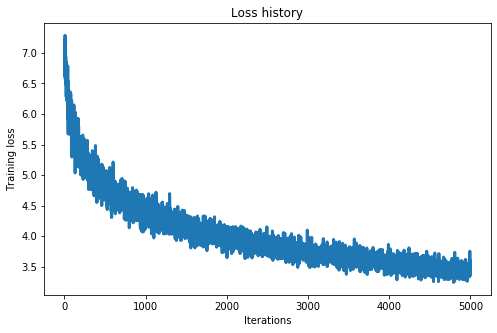

In [11]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 100

classifier = LinearClassifier(hinge_forward_backward)
#
# TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
#
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=5000, verbose = True)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

best validation accuracy achieved during cross-validation: 0.296000


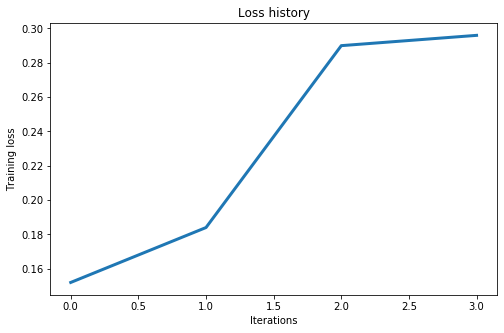

In [12]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_reg = -1
best_lr = -1
learning_rates = np.linspace(1e-8, 1e-6, 5)
regularization_strengths = np.linspace(1, 1e3, 3)
best_loss_history = []
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si tout va bien, avec num_iter = 3000    #
#  vous devriez obtenir une précision de classification supérieur à 0.30 sur #
#  l'ensemble de validation, et de 0.36 sur l'ensemble de test.              #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################

# Since the search space provided for each parameter is of low cardinality, we
# will simply execute a grid search of all possible combinations

search_space = list(it.product(learning_rates, regularization_strengths))

for lr, reg in search_space:
    
    # Initialization of classifier
    classifier = LinearClassifier(hinge_forward_backward)
    
    # Training of the classifier with a sample of hyperparameters
    classifier.train(X_train, y_train, lr, reg=reg, num_iter=3000)
    
    # Calculation of the accuracy
    accuracy = np.mean(classifier.predict(X_val) == y_val)
    
    # Update of the best values
    if accuracy > best_val:
        
        best_val, best_reg, best_lr = accuracy, reg, lr
        best_classifier = classifier
        best_loss_history.append(best_val)
    
################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [13]:
# En réentraine avec plus d'itérations
classifier = LinearClassifier(hinge_forward_backward)
train_loss_history = classifier.train(X_train, y_train, learning_rate=best_lr, reg=best_reg, num_iter=6000, verbose = True)

# On évalue la performance sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Linear model with Hinge loss : CIFAR-10 final test accuracy: %f' % (test_accuracy) )

Epoch 0 - Loss : 21.7793
Epoch 1 - Loss : 20.80878
Epoch 2 - Loss : 20.31647
Epoch 3 - Loss : 20.02244
Epoch 4 - Loss : 20.10279
Epoch 5 - Loss : 19.77672
Epoch 6 - Loss : 19.77632
Epoch 7 - Loss : 19.7369
Epoch 8 - Loss : 19.7632
Epoch 9 - Loss : 19.23836
Epoch 10 - Loss : 19.68278
Epoch 11 - Loss : 18.87489
Epoch 12 - Loss : 19.29431
Epoch 13 - Loss : 19.01122
Epoch 14 - Loss : 19.01599
Epoch 15 - Loss : 18.75427
Epoch 16 - Loss : 18.72424
Epoch 17 - Loss : 18.36662
Epoch 18 - Loss : 18.92093
Epoch 19 - Loss : 18.81564
Epoch 20 - Loss : 18.51177
Epoch 21 - Loss : 18.13481
Epoch 22 - Loss : 18.57883
Epoch 23 - Loss : 18.25161
Epoch 24 - Loss : 18.23155
Epoch 25 - Loss : 18.38776
Epoch 26 - Loss : 18.12555
Epoch 27 - Loss : 18.21665
Epoch 28 - Loss : 18.12017
Epoch 29 - Loss : 17.77826
Epoch 30 - Loss : 17.68927
Epoch 31 - Loss : 17.87457
Epoch 32 - Loss : 17.81629
Epoch 33 - Loss : 17.67724
Epoch 34 - Loss : 17.59654
Epoch 35 - Loss : 17.55702
Epoch 36 - Loss : 17.57811
Epoch 37 - Los

Epoch 299 - Loss : 10.18893
Epoch 300 - Loss : 9.9597
Epoch 301 - Loss : 9.93135
Epoch 302 - Loss : 9.94263
Epoch 303 - Loss : 9.92209
Epoch 304 - Loss : 9.99202
Epoch 305 - Loss : 9.97135
Epoch 306 - Loss : 9.97612
Epoch 307 - Loss : 9.95293
Epoch 308 - Loss : 9.79024
Epoch 309 - Loss : 9.79996
Epoch 310 - Loss : 9.92444
Epoch 311 - Loss : 9.81468
Epoch 312 - Loss : 9.77489
Epoch 313 - Loss : 9.67566
Epoch 314 - Loss : 9.70841
Epoch 315 - Loss : 9.71599
Epoch 316 - Loss : 9.74698
Epoch 317 - Loss : 9.6583
Epoch 318 - Loss : 9.68052
Epoch 319 - Loss : 9.62857
Epoch 320 - Loss : 9.70873
Epoch 321 - Loss : 9.60672
Epoch 322 - Loss : 9.67982
Epoch 323 - Loss : 9.61401
Epoch 324 - Loss : 9.7378
Epoch 325 - Loss : 9.5183
Epoch 326 - Loss : 9.58754
Epoch 327 - Loss : 9.54113
Epoch 328 - Loss : 9.48601
Epoch 329 - Loss : 9.38551
Epoch 330 - Loss : 9.41031
Epoch 331 - Loss : 9.37351
Epoch 332 - Loss : 9.32329
Epoch 333 - Loss : 9.31563
Epoch 334 - Loss : 9.34896
Epoch 335 - Loss : 9.3772
Epoch

Epoch 611 - Loss : 5.631
Epoch 612 - Loss : 5.71573
Epoch 613 - Loss : 5.76225
Epoch 614 - Loss : 5.68855
Epoch 615 - Loss : 5.65758
Epoch 616 - Loss : 5.61419
Epoch 617 - Loss : 5.6746
Epoch 618 - Loss : 5.52636
Epoch 619 - Loss : 5.65388
Epoch 620 - Loss : 5.6576
Epoch 621 - Loss : 5.6204
Epoch 622 - Loss : 5.5117
Epoch 623 - Loss : 5.5387
Epoch 624 - Loss : 5.52941
Epoch 625 - Loss : 5.50549
Epoch 626 - Loss : 5.49991
Epoch 627 - Loss : 5.59406
Epoch 628 - Loss : 5.60356
Epoch 629 - Loss : 5.50387
Epoch 630 - Loss : 5.48979
Epoch 631 - Loss : 5.50843
Epoch 632 - Loss : 5.48262
Epoch 633 - Loss : 5.51132
Epoch 634 - Loss : 5.48179
Epoch 635 - Loss : 5.42238
Epoch 636 - Loss : 5.43556
Epoch 637 - Loss : 5.44127
Epoch 638 - Loss : 5.49486
Epoch 639 - Loss : 5.42349
Epoch 640 - Loss : 5.38298
Epoch 641 - Loss : 5.51349
Epoch 642 - Loss : 5.39032
Epoch 643 - Loss : 5.37143
Epoch 644 - Loss : 5.39218
Epoch 645 - Loss : 5.36884
Epoch 646 - Loss : 5.39025
Epoch 647 - Loss : 5.34191
Epoch 64

Epoch 923 - Loss : 3.45432
Epoch 924 - Loss : 3.48658
Epoch 925 - Loss : 3.48925
Epoch 926 - Loss : 3.55557
Epoch 927 - Loss : 3.45102
Epoch 928 - Loss : 3.44693
Epoch 929 - Loss : 3.41298
Epoch 930 - Loss : 3.42833
Epoch 931 - Loss : 3.44241
Epoch 932 - Loss : 3.44978
Epoch 933 - Loss : 3.47018
Epoch 934 - Loss : 3.45646
Epoch 935 - Loss : 3.36539
Epoch 936 - Loss : 3.41434
Epoch 937 - Loss : 3.45505
Epoch 938 - Loss : 3.3889
Epoch 939 - Loss : 3.37745
Epoch 940 - Loss : 3.47196
Epoch 941 - Loss : 3.37832
Epoch 942 - Loss : 3.41851
Epoch 943 - Loss : 3.46458
Epoch 944 - Loss : 3.32779
Epoch 945 - Loss : 3.32741
Epoch 946 - Loss : 3.38374
Epoch 947 - Loss : 3.37379
Epoch 948 - Loss : 3.38524
Epoch 949 - Loss : 3.34395
Epoch 950 - Loss : 3.37041
Epoch 951 - Loss : 3.33853
Epoch 952 - Loss : 3.34506
Epoch 953 - Loss : 3.28304
Epoch 954 - Loss : 3.32545
Epoch 955 - Loss : 3.33311
Epoch 956 - Loss : 3.35153
Epoch 957 - Loss : 3.29741
Epoch 958 - Loss : 3.3747
Epoch 959 - Loss : 3.35281
Epo

Epoch 1232 - Loss : 2.44825
Epoch 1233 - Loss : 2.40711
Epoch 1234 - Loss : 2.4142
Epoch 1235 - Loss : 2.49725
Epoch 1236 - Loss : 2.43929
Epoch 1237 - Loss : 2.66369
Epoch 1238 - Loss : 2.41012
Epoch 1239 - Loss : 2.34058
Epoch 1240 - Loss : 2.35805
Epoch 1241 - Loss : 2.31905
Epoch 1242 - Loss : 2.32919
Epoch 1243 - Loss : 2.33522
Epoch 1244 - Loss : 2.32211
Epoch 1245 - Loss : 2.40429
Epoch 1246 - Loss : 2.38813
Epoch 1247 - Loss : 2.34734
Epoch 1248 - Loss : 2.31721
Epoch 1249 - Loss : 2.33581
Epoch 1250 - Loss : 2.3477
Epoch 1251 - Loss : 2.40938
Epoch 1252 - Loss : 2.35965
Epoch 1253 - Loss : 2.36507
Epoch 1254 - Loss : 2.41628
Epoch 1255 - Loss : 2.43677
Epoch 1256 - Loss : 2.53441
Epoch 1257 - Loss : 2.34803
Epoch 1258 - Loss : 2.34333
Epoch 1259 - Loss : 2.34148
Epoch 1260 - Loss : 2.31752
Epoch 1261 - Loss : 2.28543
Epoch 1262 - Loss : 2.33631
Epoch 1263 - Loss : 2.43217
Epoch 1264 - Loss : 2.35747
Epoch 1265 - Loss : 2.37623
Epoch 1266 - Loss : 2.35081
Epoch 1267 - Loss : 2.

Epoch 1544 - Loss : 1.92096
Epoch 1545 - Loss : 1.93502
Epoch 1546 - Loss : 1.84781
Epoch 1547 - Loss : 1.84381
Epoch 1548 - Loss : 1.87085
Epoch 1549 - Loss : 1.98408
Epoch 1550 - Loss : 1.88746
Epoch 1551 - Loss : 1.88696
Epoch 1552 - Loss : 1.92201
Epoch 1553 - Loss : 1.82354
Epoch 1554 - Loss : 1.82269
Epoch 1555 - Loss : 1.97265
Epoch 1556 - Loss : 1.90075
Epoch 1557 - Loss : 1.92106
Epoch 1558 - Loss : 1.98358
Epoch 1559 - Loss : 1.92494
Epoch 1560 - Loss : 1.84765
Epoch 1561 - Loss : 1.82572
Epoch 1562 - Loss : 1.86009
Epoch 1563 - Loss : 1.79556
Epoch 1564 - Loss : 1.77786
Epoch 1565 - Loss : 1.84774
Epoch 1566 - Loss : 1.90446
Epoch 1567 - Loss : 1.87871
Epoch 1568 - Loss : 1.83741
Epoch 1569 - Loss : 1.8798
Epoch 1570 - Loss : 1.76946
Epoch 1571 - Loss : 1.88977
Epoch 1572 - Loss : 1.95095
Epoch 1573 - Loss : 1.76343
Epoch 1574 - Loss : 1.76348
Epoch 1575 - Loss : 1.76468
Epoch 1576 - Loss : 1.84437
Epoch 1577 - Loss : 1.90432
Epoch 1578 - Loss : 1.86652
Epoch 1579 - Loss : 1

Epoch 1856 - Loss : 1.62438
Epoch 1857 - Loss : 1.55123
Epoch 1858 - Loss : 1.57968
Epoch 1859 - Loss : 1.46222
Epoch 1860 - Loss : 1.53351
Epoch 1861 - Loss : 1.67219
Epoch 1862 - Loss : 1.51747
Epoch 1863 - Loss : 1.5958
Epoch 1864 - Loss : 1.71107
Epoch 1865 - Loss : 1.72284
Epoch 1866 - Loss : 1.61315
Epoch 1867 - Loss : 1.56519
Epoch 1868 - Loss : 1.48103
Epoch 1869 - Loss : 1.54018
Epoch 1870 - Loss : 1.52936
Epoch 1871 - Loss : 1.52907
Epoch 1872 - Loss : 1.52224
Epoch 1873 - Loss : 1.57505
Epoch 1874 - Loss : 1.57821
Epoch 1875 - Loss : 1.62869
Epoch 1876 - Loss : 1.62528
Epoch 1877 - Loss : 1.61863
Epoch 1878 - Loss : 1.59818
Epoch 1879 - Loss : 1.55529
Epoch 1880 - Loss : 1.54535
Epoch 1881 - Loss : 1.55436
Epoch 1882 - Loss : 1.58651
Epoch 1883 - Loss : 1.65888
Epoch 1884 - Loss : 1.57623
Epoch 1885 - Loss : 1.62719
Epoch 1886 - Loss : 1.50389
Epoch 1887 - Loss : 1.53184
Epoch 1888 - Loss : 1.63444
Epoch 1889 - Loss : 1.71122
Epoch 1890 - Loss : 1.57358
Epoch 1891 - Loss : 1

Epoch 2168 - Loss : 1.41196
Epoch 2169 - Loss : 1.39779
Epoch 2170 - Loss : 1.54607
Epoch 2171 - Loss : 1.52963
Epoch 2172 - Loss : 1.47116
Epoch 2173 - Loss : 1.42098
Epoch 2174 - Loss : 1.37299
Epoch 2175 - Loss : 1.37666
Epoch 2176 - Loss : 1.35043
Epoch 2177 - Loss : 1.39468
Epoch 2178 - Loss : 1.43285
Epoch 2179 - Loss : 1.50931
Epoch 2180 - Loss : 1.46782
Epoch 2181 - Loss : 1.39604
Epoch 2182 - Loss : 1.50873
Epoch 2183 - Loss : 1.50539
Epoch 2184 - Loss : 1.62255
Epoch 2185 - Loss : 1.39269
Epoch 2186 - Loss : 1.38848
Epoch 2187 - Loss : 1.39493
Epoch 2188 - Loss : 1.3263
Epoch 2189 - Loss : 1.39131
Epoch 2190 - Loss : 1.40086
Epoch 2191 - Loss : 1.44192
Epoch 2192 - Loss : 1.5718
Epoch 2193 - Loss : 1.56761
Epoch 2194 - Loss : 1.37029
Epoch 2195 - Loss : 1.4022
Epoch 2196 - Loss : 1.57574
Epoch 2197 - Loss : 1.54497
Epoch 2198 - Loss : 1.32919
Epoch 2199 - Loss : 1.41663
Epoch 2200 - Loss : 1.47693
Epoch 2201 - Loss : 1.51148
Epoch 2202 - Loss : 1.41007
Epoch 2203 - Loss : 1.4

Epoch 2481 - Loss : 1.43182
Epoch 2482 - Loss : 1.42451
Epoch 2483 - Loss : 1.2705
Epoch 2484 - Loss : 1.37098
Epoch 2485 - Loss : 1.4757
Epoch 2486 - Loss : 1.51299
Epoch 2487 - Loss : 1.49964
Epoch 2488 - Loss : 1.37402
Epoch 2489 - Loss : 1.31784
Epoch 2490 - Loss : 1.28843
Epoch 2491 - Loss : 1.37033
Epoch 2492 - Loss : 1.38705
Epoch 2493 - Loss : 1.32407
Epoch 2494 - Loss : 1.37286
Epoch 2495 - Loss : 1.5364
Epoch 2496 - Loss : 1.38632
Epoch 2497 - Loss : 1.35755
Epoch 2498 - Loss : 1.44221
Epoch 2499 - Loss : 1.40618
Epoch 2500 - Loss : 1.36063
Epoch 2501 - Loss : 1.39991
Epoch 2502 - Loss : 1.50517
Epoch 2503 - Loss : 1.35785
Epoch 2504 - Loss : 1.37838
Epoch 2505 - Loss : 1.4879
Epoch 2506 - Loss : 1.478
Epoch 2507 - Loss : 1.55853
Epoch 2508 - Loss : 1.36356
Epoch 2509 - Loss : 1.50335
Epoch 2510 - Loss : 1.47876
Epoch 2511 - Loss : 1.37942
Epoch 2512 - Loss : 1.29527
Epoch 2513 - Loss : 1.33981
Epoch 2514 - Loss : 1.45718
Epoch 2515 - Loss : 1.42509
Epoch 2516 - Loss : 1.3945

Epoch 2790 - Loss : 1.31895
Epoch 2791 - Loss : 1.36614
Epoch 2792 - Loss : 1.36695
Epoch 2793 - Loss : 1.39572
Epoch 2794 - Loss : 1.27291
Epoch 2795 - Loss : 1.33716
Epoch 2796 - Loss : 1.28682
Epoch 2797 - Loss : 1.3049
Epoch 2798 - Loss : 1.36743
Epoch 2799 - Loss : 1.40559
Epoch 2800 - Loss : 1.41021
Epoch 2801 - Loss : 1.4725
Epoch 2802 - Loss : 1.28262
Epoch 2803 - Loss : 1.33077
Epoch 2804 - Loss : 1.29572
Epoch 2805 - Loss : 1.4338
Epoch 2806 - Loss : 1.47672
Epoch 2807 - Loss : 1.25157
Epoch 2808 - Loss : 1.23775
Epoch 2809 - Loss : 1.28698
Epoch 2810 - Loss : 1.33907
Epoch 2811 - Loss : 1.27068
Epoch 2812 - Loss : 1.40836
Epoch 2813 - Loss : 1.37185
Epoch 2814 - Loss : 1.37008
Epoch 2815 - Loss : 1.34281
Epoch 2816 - Loss : 1.31327
Epoch 2817 - Loss : 1.28438
Epoch 2818 - Loss : 1.37633
Epoch 2819 - Loss : 1.41801
Epoch 2820 - Loss : 1.4404
Epoch 2821 - Loss : 1.36924
Epoch 2822 - Loss : 1.31304
Epoch 2823 - Loss : 1.40905
Epoch 2824 - Loss : 1.40256
Epoch 2825 - Loss : 1.35

Epoch 3085 - Loss : 1.24406
Epoch 3086 - Loss : 1.3841
Epoch 3087 - Loss : 1.39107
Epoch 3088 - Loss : 1.28227
Epoch 3089 - Loss : 1.28586
Epoch 3090 - Loss : 1.27039
Epoch 3091 - Loss : 1.30634
Epoch 3092 - Loss : 1.3742
Epoch 3093 - Loss : 1.46103
Epoch 3094 - Loss : 1.32111
Epoch 3095 - Loss : 1.23781
Epoch 3096 - Loss : 1.32663
Epoch 3097 - Loss : 1.33658
Epoch 3098 - Loss : 1.3122
Epoch 3099 - Loss : 1.2216
Epoch 3100 - Loss : 1.2407
Epoch 3101 - Loss : 1.28355
Epoch 3102 - Loss : 1.33618
Epoch 3103 - Loss : 1.30687
Epoch 3104 - Loss : 1.43974
Epoch 3105 - Loss : 1.51212
Epoch 3106 - Loss : 1.25111
Epoch 3107 - Loss : 1.31734
Epoch 3108 - Loss : 1.24576
Epoch 3109 - Loss : 1.22869
Epoch 3110 - Loss : 1.27928
Epoch 3111 - Loss : 1.33842
Epoch 3112 - Loss : 1.4121
Epoch 3113 - Loss : 1.35626
Epoch 3114 - Loss : 1.30576
Epoch 3115 - Loss : 1.28003
Epoch 3116 - Loss : 1.21543
Epoch 3117 - Loss : 1.28301
Epoch 3118 - Loss : 1.34793
Epoch 3119 - Loss : 1.31299
Epoch 3120 - Loss : 1.2215

Epoch 3379 - Loss : 1.26453
Epoch 3380 - Loss : 1.30476
Epoch 3381 - Loss : 1.30804
Epoch 3382 - Loss : 1.30226
Epoch 3383 - Loss : 1.26481
Epoch 3384 - Loss : 1.32579
Epoch 3385 - Loss : 1.34625
Epoch 3386 - Loss : 1.18165
Epoch 3387 - Loss : 1.23142
Epoch 3388 - Loss : 1.25728
Epoch 3389 - Loss : 1.31674
Epoch 3390 - Loss : 1.33522
Epoch 3391 - Loss : 1.27269
Epoch 3392 - Loss : 1.36541
Epoch 3393 - Loss : 1.32255
Epoch 3394 - Loss : 1.40877
Epoch 3395 - Loss : 1.23264
Epoch 3396 - Loss : 1.26642
Epoch 3397 - Loss : 1.28558
Epoch 3398 - Loss : 1.47028
Epoch 3399 - Loss : 1.31778
Epoch 3400 - Loss : 1.32494
Epoch 3401 - Loss : 1.24548
Epoch 3402 - Loss : 1.36917
Epoch 3403 - Loss : 1.38303
Epoch 3404 - Loss : 1.38965
Epoch 3405 - Loss : 1.2878
Epoch 3406 - Loss : 1.29735
Epoch 3407 - Loss : 1.23653
Epoch 3408 - Loss : 1.32216
Epoch 3409 - Loss : 1.24985
Epoch 3410 - Loss : 1.20668
Epoch 3411 - Loss : 1.21946
Epoch 3412 - Loss : 1.32711
Epoch 3413 - Loss : 1.36958
Epoch 3414 - Loss : 1

Epoch 3689 - Loss : 1.2273
Epoch 3690 - Loss : 1.21993
Epoch 3691 - Loss : 1.23938
Epoch 3692 - Loss : 1.23889
Epoch 3693 - Loss : 1.1851
Epoch 3694 - Loss : 1.23198
Epoch 3695 - Loss : 1.29455
Epoch 3696 - Loss : 1.35339
Epoch 3697 - Loss : 1.28136
Epoch 3698 - Loss : 1.34894
Epoch 3699 - Loss : 1.21388
Epoch 3700 - Loss : 1.20434
Epoch 3701 - Loss : 1.24262
Epoch 3702 - Loss : 1.36843
Epoch 3703 - Loss : 1.41143
Epoch 3704 - Loss : 1.43753
Epoch 3705 - Loss : 1.25543
Epoch 3706 - Loss : 1.20161
Epoch 3707 - Loss : 1.18201
Epoch 3708 - Loss : 1.15159
Epoch 3709 - Loss : 1.17359
Epoch 3710 - Loss : 1.23768
Epoch 3711 - Loss : 1.32862
Epoch 3712 - Loss : 1.35299
Epoch 3713 - Loss : 1.28726
Epoch 3714 - Loss : 1.22627
Epoch 3715 - Loss : 1.24633
Epoch 3716 - Loss : 1.2504
Epoch 3717 - Loss : 1.23291
Epoch 3718 - Loss : 1.23135
Epoch 3719 - Loss : 1.28816
Epoch 3720 - Loss : 1.30697
Epoch 3721 - Loss : 1.31815
Epoch 3722 - Loss : 1.30551
Epoch 3723 - Loss : 1.39091
Epoch 3724 - Loss : 1.2

Epoch 3999 - Loss : 1.28618
Epoch 4000 - Loss : 1.27666
Epoch 4001 - Loss : 1.32866
Epoch 4002 - Loss : 1.25974
Epoch 4003 - Loss : 1.28608
Epoch 4004 - Loss : 1.24476
Epoch 4005 - Loss : 1.25414
Epoch 4006 - Loss : 1.30215
Epoch 4007 - Loss : 1.41124
Epoch 4008 - Loss : 1.35472
Epoch 4009 - Loss : 1.29314
Epoch 4010 - Loss : 1.26046
Epoch 4011 - Loss : 1.26237
Epoch 4012 - Loss : 1.32739
Epoch 4013 - Loss : 1.19243
Epoch 4014 - Loss : 1.26122
Epoch 4015 - Loss : 1.36153
Epoch 4016 - Loss : 1.26447
Epoch 4017 - Loss : 1.30852
Epoch 4018 - Loss : 1.25763
Epoch 4019 - Loss : 1.35364
Epoch 4020 - Loss : 1.20066
Epoch 4021 - Loss : 1.25757
Epoch 4022 - Loss : 1.18337
Epoch 4023 - Loss : 1.19944
Epoch 4024 - Loss : 1.27689
Epoch 4025 - Loss : 1.45287
Epoch 4026 - Loss : 1.31035
Epoch 4027 - Loss : 1.28539
Epoch 4028 - Loss : 1.17569
Epoch 4029 - Loss : 1.21405
Epoch 4030 - Loss : 1.32143
Epoch 4031 - Loss : 1.28707
Epoch 4032 - Loss : 1.41751
Epoch 4033 - Loss : 1.27928
Epoch 4034 - Loss : 

Epoch 4309 - Loss : 1.38898
Epoch 4310 - Loss : 1.3494
Epoch 4311 - Loss : 1.32018
Epoch 4312 - Loss : 1.2444
Epoch 4313 - Loss : 1.24187
Epoch 4314 - Loss : 1.2481
Epoch 4315 - Loss : 1.30189
Epoch 4316 - Loss : 1.37583
Epoch 4317 - Loss : 1.19439
Epoch 4318 - Loss : 1.22174
Epoch 4319 - Loss : 1.39703
Epoch 4320 - Loss : 1.31162
Epoch 4321 - Loss : 1.27085
Epoch 4322 - Loss : 1.30395
Epoch 4323 - Loss : 1.37596
Epoch 4324 - Loss : 1.24358
Epoch 4325 - Loss : 1.2207
Epoch 4326 - Loss : 1.2692
Epoch 4327 - Loss : 1.29576
Epoch 4328 - Loss : 1.38893
Epoch 4329 - Loss : 1.37258
Epoch 4330 - Loss : 1.37184
Epoch 4331 - Loss : 1.33971
Epoch 4332 - Loss : 1.54195
Epoch 4333 - Loss : 1.34506
Epoch 4334 - Loss : 1.3999
Epoch 4335 - Loss : 1.28023
Epoch 4336 - Loss : 1.15356
Epoch 4337 - Loss : 1.17649
Epoch 4338 - Loss : 1.19357
Epoch 4339 - Loss : 1.28272
Epoch 4340 - Loss : 1.24626
Epoch 4341 - Loss : 1.25515
Epoch 4342 - Loss : 1.29994
Epoch 4343 - Loss : 1.29156
Epoch 4344 - Loss : 1.3307

Epoch 4615 - Loss : 1.32655
Epoch 4616 - Loss : 1.27191
Epoch 4617 - Loss : 1.28016
Epoch 4618 - Loss : 1.25935
Epoch 4619 - Loss : 1.26466
Epoch 4620 - Loss : 1.25771
Epoch 4621 - Loss : 1.36473
Epoch 4622 - Loss : 1.29545
Epoch 4623 - Loss : 1.2657
Epoch 4624 - Loss : 1.42507
Epoch 4625 - Loss : 1.20934
Epoch 4626 - Loss : 1.24768
Epoch 4627 - Loss : 1.27121
Epoch 4628 - Loss : 1.33051
Epoch 4629 - Loss : 1.32418
Epoch 4630 - Loss : 1.33964
Epoch 4631 - Loss : 1.1491
Epoch 4632 - Loss : 1.26414
Epoch 4633 - Loss : 1.30277
Epoch 4634 - Loss : 1.33163
Epoch 4635 - Loss : 1.38222
Epoch 4636 - Loss : 1.21237
Epoch 4637 - Loss : 1.15019
Epoch 4638 - Loss : 1.22102
Epoch 4639 - Loss : 1.24841
Epoch 4640 - Loss : 1.24318
Epoch 4641 - Loss : 1.20271
Epoch 4642 - Loss : 1.28661
Epoch 4643 - Loss : 1.37745
Epoch 4644 - Loss : 1.52167
Epoch 4645 - Loss : 1.41911
Epoch 4646 - Loss : 1.30676
Epoch 4647 - Loss : 1.32525
Epoch 4648 - Loss : 1.3409
Epoch 4649 - Loss : 1.34206
Epoch 4650 - Loss : 1.1

Epoch 4913 - Loss : 1.17004
Epoch 4914 - Loss : 1.25833
Epoch 4915 - Loss : 1.21114
Epoch 4916 - Loss : 1.16727
Epoch 4917 - Loss : 1.29625
Epoch 4918 - Loss : 1.41575
Epoch 4919 - Loss : 1.28066
Epoch 4920 - Loss : 1.28852
Epoch 4921 - Loss : 1.32327
Epoch 4922 - Loss : 1.28937
Epoch 4923 - Loss : 1.20111
Epoch 4924 - Loss : 1.23861
Epoch 4925 - Loss : 1.22734
Epoch 4926 - Loss : 1.37314
Epoch 4927 - Loss : 1.39221
Epoch 4928 - Loss : 1.41334
Epoch 4929 - Loss : 1.3259
Epoch 4930 - Loss : 1.22038
Epoch 4931 - Loss : 1.16289
Epoch 4932 - Loss : 1.21562
Epoch 4933 - Loss : 1.44893
Epoch 4934 - Loss : 1.28466
Epoch 4935 - Loss : 1.27498
Epoch 4936 - Loss : 1.27126
Epoch 4937 - Loss : 1.34378
Epoch 4938 - Loss : 1.28446
Epoch 4939 - Loss : 1.27572
Epoch 4940 - Loss : 1.2691
Epoch 4941 - Loss : 1.35193
Epoch 4942 - Loss : 1.37188
Epoch 4943 - Loss : 1.30293
Epoch 4944 - Loss : 1.28098
Epoch 4945 - Loss : 1.29486
Epoch 4946 - Loss : 1.48142
Epoch 4947 - Loss : 1.48317
Epoch 4948 - Loss : 1.

Epoch 5231 - Loss : 1.26369
Epoch 5232 - Loss : 1.38053
Epoch 5233 - Loss : 1.27965
Epoch 5234 - Loss : 1.22778
Epoch 5235 - Loss : 1.28656
Epoch 5236 - Loss : 1.28454
Epoch 5237 - Loss : 1.32894
Epoch 5238 - Loss : 1.26847
Epoch 5239 - Loss : 1.29906
Epoch 5240 - Loss : 1.32708
Epoch 5241 - Loss : 1.38814
Epoch 5242 - Loss : 1.30327
Epoch 5243 - Loss : 1.32309
Epoch 5244 - Loss : 1.2644
Epoch 5245 - Loss : 1.36176
Epoch 5246 - Loss : 1.27088
Epoch 5247 - Loss : 1.26662
Epoch 5248 - Loss : 1.29297
Epoch 5249 - Loss : 1.32311
Epoch 5250 - Loss : 1.28355
Epoch 5251 - Loss : 1.28767
Epoch 5252 - Loss : 1.36277
Epoch 5253 - Loss : 1.34503
Epoch 5254 - Loss : 1.24312
Epoch 5255 - Loss : 1.24846
Epoch 5256 - Loss : 1.32696
Epoch 5257 - Loss : 1.26427
Epoch 5258 - Loss : 1.35836
Epoch 5259 - Loss : 1.39135
Epoch 5260 - Loss : 1.21007
Epoch 5261 - Loss : 1.19302
Epoch 5262 - Loss : 1.23026
Epoch 5263 - Loss : 1.25337
Epoch 5264 - Loss : 1.33395
Epoch 5265 - Loss : 1.37312
Epoch 5266 - Loss : 1

Epoch 5541 - Loss : 1.16874
Epoch 5542 - Loss : 1.21273
Epoch 5543 - Loss : 1.34822
Epoch 5544 - Loss : 1.23313
Epoch 5545 - Loss : 1.27566
Epoch 5546 - Loss : 1.30821
Epoch 5547 - Loss : 1.29443
Epoch 5548 - Loss : 1.30638
Epoch 5549 - Loss : 1.2491
Epoch 5550 - Loss : 1.28651
Epoch 5551 - Loss : 1.1952
Epoch 5552 - Loss : 1.21538
Epoch 5553 - Loss : 1.21507
Epoch 5554 - Loss : 1.32167
Epoch 5555 - Loss : 1.26294
Epoch 5556 - Loss : 1.43009
Epoch 5557 - Loss : 1.36203
Epoch 5558 - Loss : 1.32228
Epoch 5559 - Loss : 1.28679
Epoch 5560 - Loss : 1.31281
Epoch 5561 - Loss : 1.33492
Epoch 5562 - Loss : 1.15285
Epoch 5563 - Loss : 1.23443
Epoch 5564 - Loss : 1.45371
Epoch 5565 - Loss : 1.42995
Epoch 5566 - Loss : 1.35263
Epoch 5567 - Loss : 1.22752
Epoch 5568 - Loss : 1.20838
Epoch 5569 - Loss : 1.23081
Epoch 5570 - Loss : 1.28387
Epoch 5571 - Loss : 1.32
Epoch 5572 - Loss : 1.21708
Epoch 5573 - Loss : 1.29941
Epoch 5574 - Loss : 1.42689
Epoch 5575 - Loss : 1.31531
Epoch 5576 - Loss : 1.221

Epoch 5858 - Loss : 1.44781
Epoch 5859 - Loss : 1.19626
Epoch 5860 - Loss : 1.20844
Epoch 5861 - Loss : 1.22557
Epoch 5862 - Loss : 1.3367
Epoch 5863 - Loss : 1.33648
Epoch 5864 - Loss : 1.25783
Epoch 5865 - Loss : 1.27676
Epoch 5866 - Loss : 1.20646
Epoch 5867 - Loss : 1.24624
Epoch 5868 - Loss : 1.18129
Epoch 5869 - Loss : 1.28639
Epoch 5870 - Loss : 1.32286
Epoch 5871 - Loss : 1.2915
Epoch 5872 - Loss : 1.22928
Epoch 5873 - Loss : 1.28807
Epoch 5874 - Loss : 1.37111
Epoch 5875 - Loss : 1.38427
Epoch 5876 - Loss : 1.25307
Epoch 5877 - Loss : 1.23073
Epoch 5878 - Loss : 1.32966
Epoch 5879 - Loss : 1.21765
Epoch 5880 - Loss : 1.27497
Epoch 5881 - Loss : 1.39023
Epoch 5882 - Loss : 1.2816
Epoch 5883 - Loss : 1.25313
Epoch 5884 - Loss : 1.29727
Epoch 5885 - Loss : 1.32899
Epoch 5886 - Loss : 1.27861
Epoch 5887 - Loss : 1.32294
Epoch 5888 - Loss : 1.36876
Epoch 5889 - Loss : 1.29952
Epoch 5890 - Loss : 1.25227
Epoch 5891 - Loss : 1.29111
Epoch 5892 - Loss : 1.30022
Epoch 5893 - Loss : 1.1

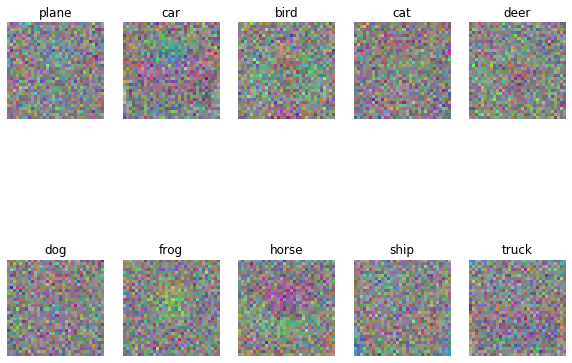

In [14]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])